In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import Diffrapy as df
import matplotlib.cm as cm
from tqdm import tqdm

from readgssi import readgssi

In [2]:
importlib.reload(df)

<module 'Diffrapy' from 'C:\\Users\\guilh\\Desktop\\Code\\SeismicDiffractions\\Diffrapy.py'>

In [3]:
sc=120 #value for static correction, change accordingly

hdr, arr, gps = readgssi.readgssi(infile="Data/GPR_files/FILE____172_bruto.DZT",zero=[sc])

data = arr[0]
A = arr[0]
cdp1=A

ntime=hdr['shape'][0] - sc
ntrace=hdr['shape'][1]
#dt=hdr['sec']/ntime

nx = ntrace
nz = ntime
dx = 0.0025   #m, found in the import.rep file, not sure how to obtain this value from readgssi...
dt = 0.0195 #ns, found in the import.rep file, not sure how to obtain this value from readgssi...

2024-04-11 17:55:49 - WARNING: no DZG file found for GPS input
2024-04-11 17:55:49 - WARNING: could not find DZX file to read metadata. Trying to read array for marks...
2024-04-11 17:55:49 - DZT marks read successfully. marks: 8
2024-04-11 17:55:49 -                             traces: [0, 40, 80, 120, 160, 200, 240, 280]
--------------------WARNING - PLEASE READ---------------------
2024-04-11 17:55:49 - WARNING: could not read frequency for antenna name "'2.6GHz'"
2024-04-11 17:55:49 - WARNING: trying to use frequencies of 2 MHz (estimated)...
2024-04-11 17:55:49 - more info: rh_ant=['2.6GHz', None, None, None]
2024-04-11 17:55:49 -            known_ant=[False, None, None, None]
2024-04-11 17:55:49 - please submit a bug report with this warning, the antenna name and frequency
2024-04-11 17:55:49 - at https://github.com/iannesbitt/readgssi/issues/new
2024-04-11 17:55:49 - or send via email to ian (dot) nesbitt (at) gmail (dot) com.
2024-04-11 17:55:49 - if possible, please attach a Z

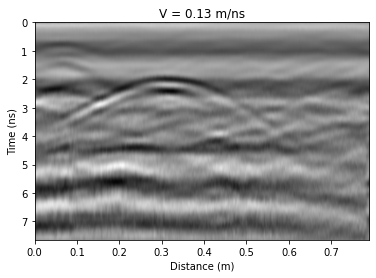

In [4]:
plt.imshow(cdp1,aspect='auto',interpolation='bicubic', cmap=plt.cm.gray_r,extent=[0*dx, ntrace*dx, ntime*dt, 0*dt])

plt.title('V = 0.13 m/ns')
plt.xlabel('Distance (m)')
plt.ylabel('Time (ns)')

plt.show()

In [5]:
c=0.13 # obtained from Reflex migration

In [26]:
from tqdm import tqdm

nx=ntrace
nz=ntime

nz = ntime
t_total = ntime*dt
z_total = (c*t_total)/2 # m
dz = z_total/nz
#dz = 0.0012675  # m

teste_time_table = np.zeros([ntrace,nx,nz]) 

In [23]:
print(np.shape(teste_time_table))

(316, 316, 392)


### alguma coisa está dando errado nessa conta do time_table...

In [35]:
dxtrace = 20

#for ixtrace in tqdm(range(0,ntrace)): #posicao do GPR
for ixtrace in tqdm(range(0,5)):
    for ixs in range(0,ns): # coord x no modelo, trocar ixs pq ñ é tiro
        for izs in range(0,nz): #coord z no modelo (tempo)
            r = np.sqrt((izs*dz)**2 + (ixtrace*dxtrace - ixs*dx)**2) 
            if r!=0:
                teste_time_table[ixtrace,ixs,izs]=r/c
            elif r==0:
                teste_time_table[ixtrace,ixs,izs]=1e-10
                
print(np.shape(teste_time_table))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.83it/s]

(316, 316, 392)


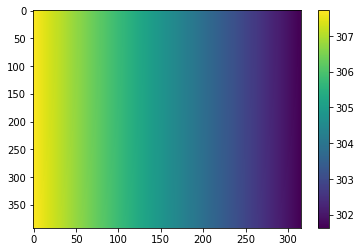

In [36]:
plt.imshow(teste_time_table[2,:,:].T,aspect="auto")
plt.colorbar()
plt.show()

In [57]:
migdata_envelope = np.loadtxt("Data/GPR_files/FILE_172_migrated4.ASC")

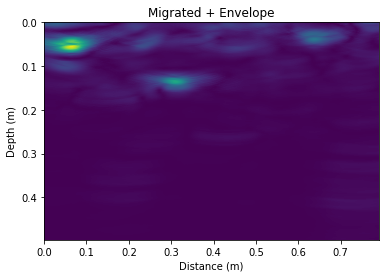

In [59]:
migdata_envelope = migdata_envelope[120:,:]

plt.imshow(migdata_envelope,aspect="auto",extent=[0,ntrace*dx,z_total,0])
plt.title("Migrated + Envelope")
plt.xlabel('Distance (m)')
plt.ylabel('Depth (m)')
plt.show()

In [63]:
pmin = -1 #45 graus
pmax = 1
dp = 0.2
xwin=zwin=5
x_ini=z_ini=0

pm,sm = df.local_window(migdata_envelope,xwin,zwin,x_ini,z_ini,dx,dz,pmin,pmax,dp)

with open("Data/GPR_files/pm", "wb") as f: 
    np.save(f, pm)
    
with open("Data/GPR_files/sm", "wb") as f: 
    np.save(f, sm)

100%|████████████████████████████████████████████████████████████████████████████████| 392/392 [00:47<00:00,  8.22it/s]


In [64]:
with open("Data/GPR_files/pm", "rb") as f:
    pm = np.load(f)

with open("Data/GPR_files/sm", "rb") as f:
    sm = np.load(f)

Alguma coisa está dando errado aqui, essas imagens estão ficando muito esquisitas... Normalmente fica algo bem parecido com a imagem migrada original

Será que a mudança de segundos pra nanosegundos faz essa confusão nas funções? 

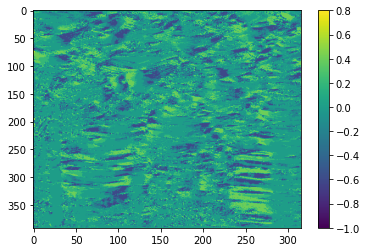

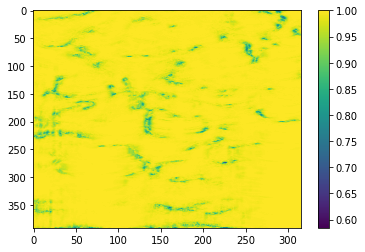

In [65]:
plt.imshow(pm,aspect="auto")
plt.colorbar()

plt.show()

plt.imshow(sm,aspect="auto")
plt.colorbar()
plt.show()

In [66]:
m_theta = np.arctan(pm)
X = np.sin(m_theta)
Y = np.cos(m_theta)

definindo constantes para a migração

In [12]:
dwin=dt
win=5*dt #Time Window
app_ref=10 #Aperture for conventional migration
app_dif=20 #Aperture for diffraction migration

gather1 = cdp1
isx = 0 #o que eu faço aqui? como é common offset, não tem isx

******

### O grande desafio está aqui!

Temos que arrumar a nossa função de migração de difrações para considerar um dado common-offset, já que a original está definida para dados common-shot. Também não sei se temos que fazer modificações por conta das unidades diferentes do dado de GPR (nanosegundos). 

In [13]:
def gprKirchhoffMigration(gather,isx,dx,dz,dt,win,dwin,app_ref,app_dif,time_table,X,Y,sm):
    
    gather = np.array(gather)
    gather = df.phase_shift(gather)

    timer=time_table

    window = np.arange(-win,win,dwin)
    [nt,ntr]=gather.shape
    [ntr2,nz,nx]=timer.shape
    if ntr!=ntr2:
        print('Gather and traveltime table have different trace numbers')
        
    refl_mig = np.zeros([nz,nx])
    diff_mig = np.zeros([nz,nx])

    IX = np.arange(0,nx*dx,dx)
    IZ = np.arange(0,nz*dz,dz)
    [IIX,IIZ] = np.meshgrid(IX,IZ)
    
    # Loop over each trace of the shot gather at src isx
    for igx in tqdm(range(0,ntr)):
        
        w = df.peso(TTh,dt,X,Y,igx,isx)
        w_reff = (w**4)*(sm)
        w_diff = (1-(w**4))
        
        trace_reflwin = np.zeros([nz,nx])
        trace_diffwin = np.zeros([nz,nx])
        
        ################################################
        ################################################
        ### MUDAR AQUI PARA CONSIDERAR COMMON-OFFSET ###
        R = np.sqrt(IIZ**2 + (IIX-(igx+isx)/2*dx)**2)
        #r = np.sqrt((ixtrace*dx-ixs*dx)**2+(izs*dx)**2)
        ################################################
        ################################################
        
        r_mask = (R==0)
        R[r_mask]= dx/1000
        obli = IIZ/R
        trace_appref = df.taper(ntr,nz,app_ref,isx,igx)
        trace_appdif = taper(ntr,nz,app_dif,isx,igx) 

        for j in range(len(window)): # somar amplitudes da curva de difração com uma janela 
            ###########################################
            ######## aqui vou ter que trocar ##########
            t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx] #t_{d}
            ###########################################
            twin = t + window[j]
            t2 = (twin<nt)*twin 
            trace1=gather.T[np.ix_([igx],t2.flatten().astype(np.int32))] 
            trace_refl1 = trace1.reshape([nz,nx])*(w_reff)
            trace_diff1 = trace1.reshape([nz,nx])*(w_diff)
            trace_refl = trace_refl1*trace_appref
            trace_diff = trace_diff1*trace_appdif
            trace_reflwin = trace_reflwin + trace_refl
            trace_diffwin = trace_diffwin + trace_diff

        refl_mig[0:nz,0:nx] = refl_mig[0:nz,0:nx] + trace_reflwin*obli
        diff_mig[0:nz,0:nx] = diff_mig[0:nz,0:nx] + trace_diffwin*obli

    mig_final = np.add.reduce(migs)
    refl_mig = np.add.reduce(refl_migs)
    diff_mig = np.add.reduce(diff_migs)
        
    return refl_mig,diff_mig

Para testar a migração, é só rodar essa célula

100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:14<00:00, 22.23it/s]


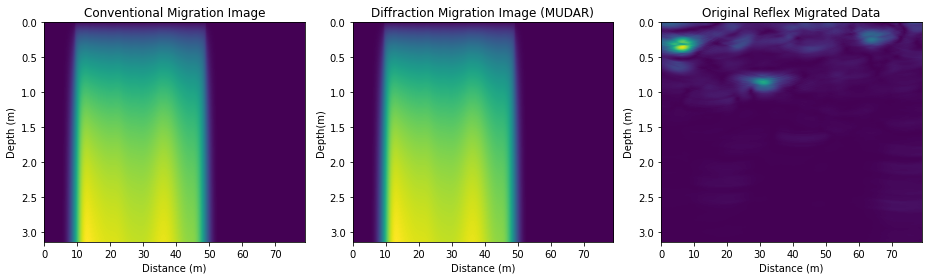

In [16]:
#refl = gprKirchhoffMigration(cdp1,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm)
refl,diff = gprKirchhoffMigration(cdp1,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm)
#refl,diff = df.kirchhoffMigration(cdp1,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Conventional Migration Image")
ax1.set_xlabel("Distance (m)")
ax1.set_ylabel("Depth (m)")

ax2.imshow(refl, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Diffraction Migration Image (MUDAR)")
ax2.set_xlabel("Distance (m)")
ax2.set_ylabel("Depth(m)")

ax3.imshow(migdata_envelope, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Original Reflex Migrated Data")
ax3.set_xlabel("Distance (m)")
ax3.set_ylabel("Depth (m)")

plt.tight_layout()
plt.show()